![for sale image, from https://jpc-chicago.com/for-sale-signs-make-custom-real-estate-signs-and-sale-yard-sign/](images/forsale.jpg)

# Predicting the Popularity of Songs on Spotify
**Author:** Shawn Samuel

---
## Overview

FILL IN AT END

---
## Business Problem

There are a lot of songs on Spotify. To the tune of [70 million tracks](https://newsroom.spotify.com/company-info/) as of December 2020 with an average of 60,000 songs being added every day. There are many variables that determine which songs out of this massive library to become popular. Considering that the worlds largest 4 music lables own [87% of the content on Spotify](https://www.thelocal.se/20180302/the-story-of-spotify-swedens-controversial-king-of-music-streaming/), what drives the popularity of a particular song is of great interest to these entities. Our goal with this project is to build a machine learning model that can predict whether a song will be popular or not based on a set of features. The popularity of the song will be based on Spotify's own proprietry ranking. This will allow record labels to determine which songs are worth putting more marketing dollars behind. 


When making decisions regarding which models and metrics to use, it is always important to determine which errors will be more costly. For our particularl case - there are the ramifications of errors:  
- **Type I Error (FP)** = predicting a song *will* be popular when it *will not*  
- **Type II Error (FN)** = predicting a song *will not* be popular when it *will*  

In this particular business case - if a song is predicted to be positive, I would recommend a record label put marketing dollars behind that song to generate more plays and more profit. A *Type I Error* would cause money to be lost up front. This would mean increased cost and also less profit - leaving the record label in the red. A *Type II Error* on the other hand, would be a loss of potential profit due to the lost opportunity of a popular song. With that in mind we would emphasis the **Precision** score as our primary metric to minimize *False Positives*. We will also consider the **F1 Score** to give us a balance of Type I and Type II errors.

---
## Data Understanding

The [spotify data set]('data/spotify_data.csv') was obtained from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and contains audio features of 175k+ songs released in between 1921 and 2021. The features are described below:

Numerical:
- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)  

Dummy:
- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content)  

Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- artists (List of artists mentioned)
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
- name (Name of the song)

---
## Data Preparation

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker #to format axes
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") #supress warnings that don't affect program
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/spotify_data.csv')

In [3]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
acousticness        174389 non-null float64
artists             174389 non-null object
danceability        174389 non-null float64
duration_ms         174389 non-null int64
energy              174389 non-null float64
explicit            174389 non-null int64
id                  174389 non-null object
instrumentalness    174389 non-null float64
key                 174389 non-null int64
liveness            174389 non-null float64
loudness            174389 non-null float64
mode                174389 non-null int64
name                174389 non-null object
popularity          174389 non-null int64
release_date        174389 non-null object
speechiness         174389 non-null float64
tempo               174389 non-null float64
valence             174389 non-null float64
year                174389 non-null int64
dtypes: float64(9), int64(6), object(4)
memory usage: 25.3+ MB


In [5]:
df.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


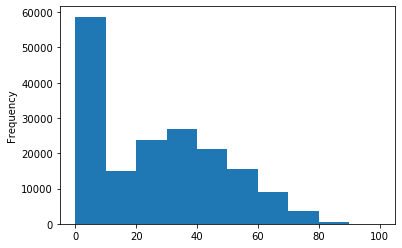

In [6]:
#explore target
df['popularity'].plot(kind='hist')

In [7]:
df['popularity'].describe()

count    174389.000000
mean         25.693381
std          21.872740
min           0.000000
25%           1.000000
50%          25.000000
75%          42.000000
max         100.000000
Name: popularity, dtype: float64

In [8]:
df['popularity'].value_counts()

0      40905
1       3846
33      2819
34      2790
36      2784
       ...  
94         5
93         2
96         2
95         2
100        1
Name: popularity, Length: 98, dtype: int64

In [9]:
df[df['popularity'] != 0]['popularity'].describe()

count    133484.000000
mean         33.566892
std          18.992977
min           1.000000
25%          20.000000
50%          33.000000
75%          47.000000
max         100.000000
Name: popularity, dtype: float64

⮕ Figure out threshold for 'popular' label

In [10]:
#there are a lot of songs with a popularity of 0
#if all 0 are removed then 33 is the mean, and also 33 has the highest value count afer 0 and 1
#we will use >=33 as the cutoff for what will be labelled as 'popular'

In [11]:
df['popular'] = np.where(df['popularity'] >= 33, 1, 0)

In [12]:
df['popular'].value_counts(normalize=True)

0    0.605204
1    0.394796
Name: popular, dtype: float64

In [13]:
#without a model, if I guessed every song was popular - I would be correct 39.48% of the time

In [14]:
features = ['acousticness', 'danceability', 'duration_ms', 
            'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 
            'loudness', 'mode', 'speechiness', 'tempo', 'valence']

In [15]:
# sns.pairplot(df, vars=features, corner=True)

⮕ importing custom pyfile with adapted evalute function from [Lindsey Berlin](https://github.com/lindseyberlin)

Functions we will use:
- sjs.crossval()
- sjs.evaluate()
- sjs.plot_feature_imp()

In [16]:
import sjs_utilities as sjs

In [17]:
SEED = 42 #set for reproduciblity

## Build Baseline Model

⮕ From features I will drop: 
- artists (not a auditory attribute of the song, but may add later)
- id (not auditory attribtue)
- name (not auditory attribute)
- release_date (not auditory attribute)
- year (not auditory attribute)
- popularity (target)
- popular (transformed target)

In [18]:
df.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'popular'],
      dtype='object')

In [19]:
# Define our X and y
X = df.drop(columns=['artists', 'id', 'name', 'release_date', 'year', 'popularity', 'popular'])
y = df['popular']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [20]:
#instantiate scaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instantiate and fit our model!
logreg = LogisticRegression(random_state=SEED)

logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

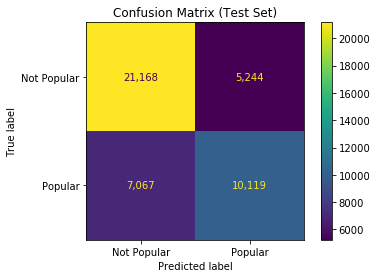

          | Train  | Test   |
          |-----------------|
Precision | 65.50% | 65.87% |
F1 Score  | 61.64% | 62.18% |
ROC-AUC   | 77.41% | 77.66% |


,Model,Precision,F1 Score,ROC-AUC
0,Baseline LogReg,65.87%,62.18%,69.51%


In [21]:
sjs.evaluate('Baseline LogReg', logreg, X_train_scaled, X_test_scaled, y_train, y_test, use_decision_function='yes')

---
## Additional Model Pipelines + CV Precision Scores

We will not build multiple initial pipelines to test various models and use CV score optimized on Precision to evalute.

### Model 1: Logistic Regression

In [22]:
# rewrite baseline logreg with minmax scaller in a pipeline

lr_mm = Pipeline([('mm', MinMaxScaler()), 
                  ('lr', LogisticRegression(random_state=SEED))])
lr_mm.fit(X_train_scaled, y_train)

sjs.crossval(lr_mm, X_train_scaled, y_train)

Avg Precision Score of 0.6552 with Std Dev of 0.0025

The scores were: ['0.6539', '0.6581', '0.6573', '0.6554', '0.6511']


In [23]:
# try logreg with standard scaler and see if any difference

lr_ss = Pipeline([('ss', StandardScaler()), 
                  ('lr', LogisticRegression(random_state=SEED))])
lr_ss.fit(X_train_scaled, y_train)

sjs.crossval(lr_ss, X_train_scaled, y_train)

Avg Precision Score of 0.6552 with Std Dev of 0.0025

The scores were: ['0.6541', '0.6580', '0.6572', '0.6554', '0.6511']


In [24]:
# no real change in scores

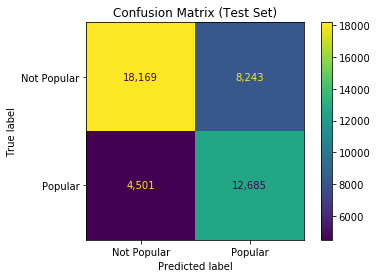

          | Train  | Test   |
          |-----------------|
Precision | 60.51% | 60.61% |
F1 Score  | 66.36% | 66.56% |
ROC-AUC   | 77.33% | 77.56% |


,Model,Precision,F1 Score,ROC-AUC
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [25]:
# let's see how dealing with imbalance impacts scores

lr_ss_bal = Pipeline([('ss', StandardScaler()), 
                      ('lr', LogisticRegression(class_weight='balanced', random_state=SEED))])
lr_ss_bal.fit(X_train_scaled, y_train)

sjs.evaluate('Balanced LogReg', lr_ss_bal, X_train_scaled, X_test_scaled, y_train, y_test, use_decision_function='yes')

In [26]:
lr_gs_ss_pipe = Pipeline([('ss', StandardScaler()), 
                          ('lr', LogisticRegression(random_state=SEED))])

param_grid = {'lr__penalty' : ['l1', 'l2'],
              'lr__C' : [100, 10, 1.0, 0.1, 0.01],
              'lr__class_weight': [None, 'balanced'],
              'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']}

lr_gs_ss = GridSearchCV(lr_gs_ss_pipe, param_grid, scoring='precision', cv=3, verbose=2)
lr_gs_ss.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=newton-cg 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=newton-cg, total=   0.1s
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=newton-cg 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=newton-cg, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=newton-cg 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=newton-cg, total=   0.0s
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=liblinear, total=   0.4s
[CV] lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__C=100, lr__class_weight=None, lr__penalty=l1, lr__solver=liblinear, total=   0.4s
[CV] lr__

[CV]  lr__C=10, lr__class_weight=None, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__C=10, lr__class_weight=None, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__C=10, lr__class_weight=None, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__C=10, lr__class_weight=None, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__C=10, lr__class_weight=None, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__C=10, lr__class_weight=balanced, lr__penalty=l1, lr__solver=newton-cg 
[CV]  lr__C=10, lr__class_weight=balanced, lr__penalty=l1, lr__solver=newton-cg, total=   0.0s
[CV] lr__C=10, lr__class_weight=balanced, lr__penalty=l1, lr__solver=newton-cg 
[CV]  lr__C=10, lr__class_weight=balanced, lr__penalty=l1, lr__solver=newton-cg, total=   0.0s
[CV] lr__C=10, lr__class_weight=balanced, lr__penalty=l1, lr__solver=newton-cg 
[CV]  lr__C=10, lr__class_weight=balanced, lr__penalty=l1, lr__solver=newton-cg, total=   0.0s
[CV] lr__C=10, lr__class_weight=balanced, lr__pena

[CV]  lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=newton-cg, total=   0.6s
[CV] lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=newton-cg 
[CV]  lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=newton-cg, total=   0.7s
[CV] lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=lbfgs, total=   0.8s
[CV] lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__C=1.0, lr__class_weight=balanced, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__C=1.0, lr__class_weight=balanced, 

KeyboardInterrupt: 

In [ ]:
print(lr_gs_ss.best_score_)
pprint(lr_gs_ss.best_estimator_.get_params())

In [ ]:
sjs.evaluate('GridSearch LogReg', lr_gs_ss.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test, use_decision_function='yes')

### Model 2: Decision Tree

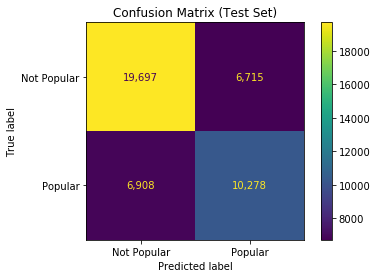

          | Train  | Test   |
          |-----------------|
Precision | 99.96% | 60.48% |
F1 Score  | 99.63% | 60.14% |
ROC-AUC   | 100.00% | 67.33% |


,Model,Precision,F1 Score,ROC-AUC
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,Vanilla Decision Tree,60.69%,60.48%,67.44%
1,Vanilla Decision Tree,60.48%,60.14%,67.19%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [25]:
#vanilla tree
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train, y_train)
sjs.evaluate('Vanilla Decision Tree', dt, X_train, X_test, y_train, y_test, use_decision_function='no')

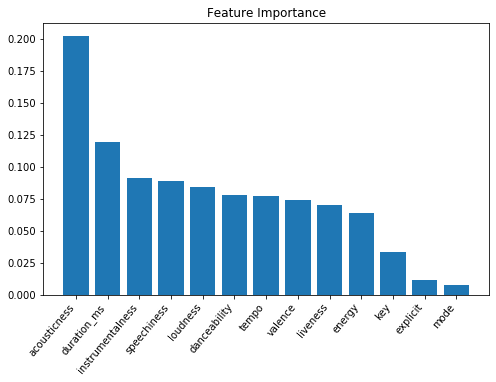

In [23]:
sjs.plot_feature_imp(dt, X)

⮕ Use graphical approach to identify optimal parameter values. Will look at:
- Max Depth
- Minimum Sample Split
- Minimum Sample Leaves
- Maximum Features

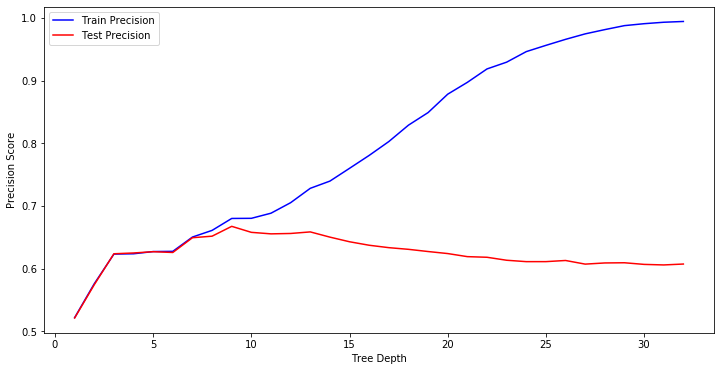

In [30]:
# Identify the optimal tree depth for given data

max_depths = list(range(1,33))
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    dt.fit(X_train, y_train)
    
    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)
    
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train Precision')
plt.plot(max_depths, test_results, 'r', label='Test Precision')
plt.ylabel('Precision Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [31]:
# tree depth of 9 looks optimal for both (7 minimizes underfitting)
# use 7, 8 & 9 for GridSearch

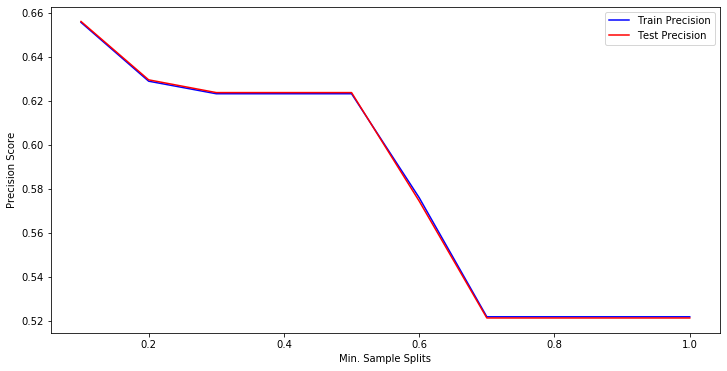

In [32]:
# Identify the optimal min-samples-split for given data

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=SEED)
    dt.fit(X_train, y_train)
    
    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train Precision')
plt.plot(min_samples_splits, test_results, 'r', label='Test Precision')
plt.ylabel('Precision Score')
plt.xlabel('Min. Sample Splits')
plt.legend()
plt.show()

In [33]:
# anywhere between .1 - .5 looks ideal 
# use .1, .2, .3 for GridSearch

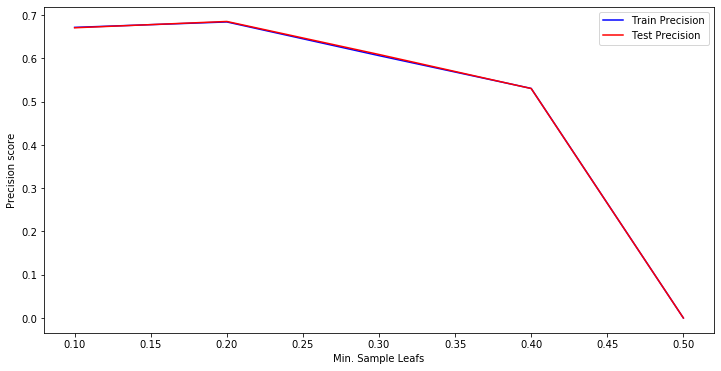

In [34]:
# Calculate the optimal value for minimum sample leafs

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=SEED)
    dt.fit(X_train, y_train)
    
    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train Precision')
plt.plot(min_samples_leafs, test_results, 'r', label='Test Precision')
plt.ylabel('Precision score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

In [35]:
# .2 is highest for train and test

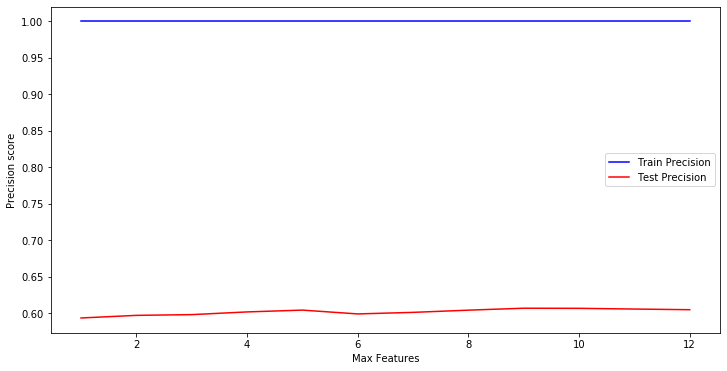

In [36]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature, random_state=SEED)
    dt.fit(X_train, y_train)

    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)
    

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train Precision')
plt.plot(max_features, test_results, 'r', label='Test Precision')
plt.ylabel('Precision score')
plt.xlabel('Max Features')
plt.legend()
plt.show()

In [37]:
test_results

[0.5937628714327744,
 0.5973364900858242,
 0.5983447790103892,
 0.6020468180214092,
 0.6045316514832983,
 0.59930151338766,
 0.6014363722697056,
 0.604460922787194,
 0.6071175218727831,
 0.6069648789748457,
 0.6059773072874021,
 0.6050813722046599]

In [38]:
# No clear effect on the training dataset - flat precision 
# Some slight fluctuations in test precision but not definitive enough to make a judgement
# Leaving out of tuning

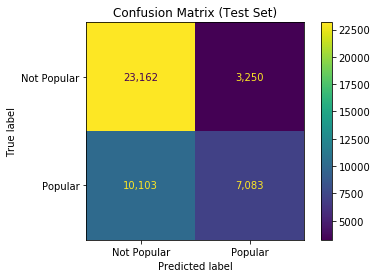

          | Train  | Test   |
          |-----------------|
Precision | 68.44% | 68.55% |
F1 Score  | 51.35% | 51.48% |
ROC-AUC   | 72.96% | 72.96% |


,Model,Precision,F1 Score,ROC-AUC
4,Tuned Decision Tree,68.55%,51.48%,64.45%
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,GridSearch LogReg,65.88%,62.15%,69.50%
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [39]:
# Train a classifier with optimal values identified above
dt2 = DecisionTreeClassifier(max_depth=9, 
                             min_samples_split=.1, 
                             min_samples_leaf=.2, 
                             random_state=SEED
                            )

dt2.fit(X_train, y_train)
sjs.evaluate('Tuned Decision Tree', dt2, X_train, X_test, y_train, y_test, use_decision_function='no')

⮕ Run GridSearch with additional options above as well as
- Criteron: Gini & Entropy
- Class Weight: None & Balanced

In [40]:
dt3 = DecisionTreeClassifier(min_samples_leaf=.2, random_state=SEED)

param_grid = {'criterion': ['gini', 'entropy'],
              'class_weight': [None, 'balanced'],
              'max_depth': [7, 8, 9],
              'min_samples_split': [.1, .2, .3]}

dt3_gs = GridSearchCV(dt3, param_grid, scoring='precision', cv=3, verbose=2)
dt3_gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.1, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.1, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.1 
[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.1, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.2 
[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.2, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.2 
[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.2, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.2 
[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.2, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.3 
[CV]  class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.3, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=7, min_samples_split=0.3

[CV]  class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.2, total=   0.2s
[CV] class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.3, total=   0.2s
[CV] class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.3, total=   0.2s
[CV] class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, min_samples_split=0.3, total=   0.2s
[CV] class_weight=balanced, criterion=gini, max_depth=7, min_samples_split=0.1 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, min_samples_split=0.1, total=   0.2s
[CV] class_weight=balanced, criterion=gini, max_depth=7, min_samples_split=0.1 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, min_samples_split=0.1, total=   0.3s
[CV] class_weight=balanced, criterion

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, min_samples_split=0.3, total=   0.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, min_samples_split=0.3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, min_samples_split=0.3, total=   0.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.1, total=   0.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.1, total=   0.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.1, total=   0.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, min_samples_split=0.2, total=   0.

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   27.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=0.2,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                 

In [41]:
print(dt3_gs.best_score_)
pprint(dt3_gs.best_estimator_.get_params())

0.6874123263142127
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}


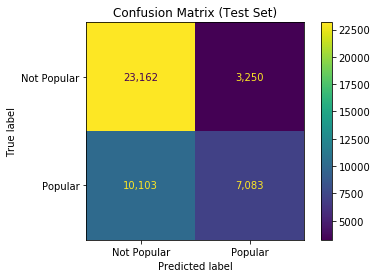

          | Train  | Test   |
          |-----------------|
Precision | 68.44% | 68.55% |
F1 Score  | 51.35% | 51.48% |
ROC-AUC   | 72.96% | 72.96% |


,Model,Precision,F1 Score,ROC-AUC
5,GridSearch Decision Tree,68.55%,51.48%,64.45%
4,Tuned Decision Tree,68.55%,51.48%,64.45%
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,GridSearch LogReg,65.88%,62.15%,69.50%
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [42]:
sjs.evaluate('GridSearch Decision Tree', dt3_gs.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='no')

In [26]:
sjs.plot_feature_imp(dt3_gs.best_estimator_, X)

NameError: name 'dt3_gs' is not defined

#### Model 3: Random Forest

⮕ Run Random Forest with the ideal decision tree parameters from above

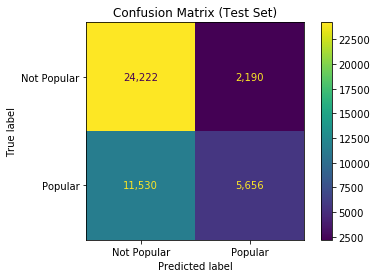

          | Train  | Test   |
          |-----------------|
Precision | 72.09% | 72.09% |
F1 Score  | 45.14% | 45.19% |
ROC-AUC   | 75.26% | 75.28% |


,Model,Precision,F1 Score,ROC-AUC
6,Random Forest,72.09%,45.19%,62.31%
5,GridSearch Decision Tree,68.55%,51.48%,64.45%
4,Tuned Decision Tree,68.55%,51.48%,64.45%
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,GridSearch LogReg,65.88%,62.15%,69.50%
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [43]:
rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf= 0.2,
                            min_samples_split=.1, 
                            n_estimators=100, 
                            random_state=SEED)
rf.fit(X_train, y_train)
sjs.evaluate('Random Forest', rf, X_train, X_test, y_train, y_test, use_decision_function='no')

In [44]:
rf2 = RandomForestClassifier(max_depth=7,
                             min_samples_split=.1,
                             min_samples_leaf= 0.2,
                             random_state=SEED)


param_grid = {'n_estimators' : [10, 100, 1000],
              'max_features' : [None, 'sqrt', 'log2']
             }

rf2_gs = GridSearchCV(rf2, param_grid, scoring='precision', cv=3, verbose=2)
rf2_gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_features=None, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... max_features=None, n_estimators=10, total=   1.3s
[CV] max_features=None, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ............... max_features=None, n_estimators=10, total=   0.9s
[CV] max_features=None, n_estimators=10 ..............................
[CV] ............... max_features=None, n_estimators=10, total=   1.1s
[CV] max_features=None, n_estimators=100 .............................
[CV] .............. max_features=None, n_estimators=100, total=   8.9s
[CV] max_features=None, n_estimators=100 .............................
[CV] .............. max_features=None, n_estimators=100, total=   7.5s
[CV] max_features=None, n_estimators=100 .............................
[CV] .............. max_features=None, n_estimators=100, total=  10.3s
[CV] max_features=None, n_estimators=1000 ............................
[CV] ............. max_features=None, n_estimators=1000, total= 1.4min
[CV] max_features=None, n_estimators=1000 ............................
[CV] ............. max_features=None, n_estimators=1000, total= 1.3min
[CV] max_features=None, n_estimators=1000 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  8.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=7,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=0.2,
                                              min_samples_split=0.1,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [45]:
print(rf2_gs.best_score_)
pprint(rf2_gs.best_estimator_.get_params())

0.7268408203831173
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


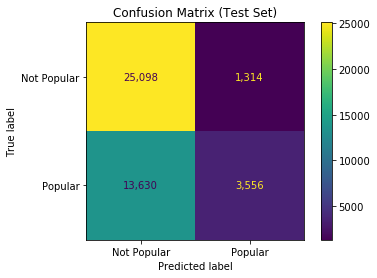

          | Train  | Test   |
          |-----------------|
Precision | 72.57% | 73.02% |
F1 Score  | 32.63% | 32.25% |
ROC-AUC   | 73.83% | 74.06% |


,Model,Precision,F1 Score,ROC-AUC
7,GridSearch Random Forest,73.02%,32.25%,57.86%
6,Random Forest,72.09%,45.19%,62.31%
5,GridSearch Decision Tree,68.55%,51.48%,64.45%
4,Tuned Decision Tree,68.55%,51.48%,64.45%
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,GridSearch LogReg,65.88%,62.15%,69.50%
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [46]:
sjs.evaluate('GridSearch Random Forest', rf2_gs.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='no')

In [ ]:
sjs.plot_feature_imp(rf2_gs.best_estimator_, X)

In [47]:
# Let's try Gradient Booster

GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)
sjs.crossval(GB, X_train, y_train)

Avg Precision Score of 0.6812 with Std Dev of 0.0050

The scores were: ['0.6803', '0.6899', '0.6830', '0.6763', '0.6767']


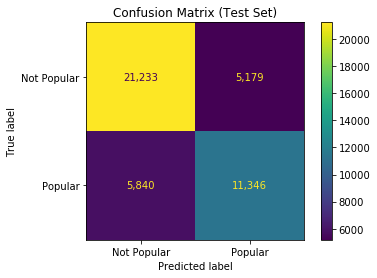

          | Train  | Test   |
          |-----------------|
Precision | 68.58% | 68.66% |
F1 Score  | 67.09% | 67.31% |
ROC-AUC   | 82.24% | 82.35% |


,Model,Precision,F1 Score,ROC-AUC
8,Gradient Boosting,68.66%,67.31%,73.21%
7,GridSearch Random Forest,73.02%,32.25%,57.86%
6,Random Forest,72.09%,45.19%,62.31%
5,GridSearch Decision Tree,68.55%,51.48%,64.45%
4,Tuned Decision Tree,68.55%,51.48%,64.45%
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,GridSearch LogReg,65.88%,62.15%,69.50%
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [48]:
sjs.evaluate('Gradient Boosting', GB, X_train, X_test, y_train, y_test, use_decision_function='no')

In [ ]:
sjs.plot_feature_imp(GB, X)

In [49]:
# Let's try XGBoost Classifier

XGB = XGBClassifier()
XGB.fit(X_train, y_train)

sjs.crossval(XGB, X_train, y_train)

Avg Precision Score of 0.6798 with Std Dev of 0.0045

The scores were: ['0.6787', '0.6876', '0.6813', '0.6745', '0.6768']


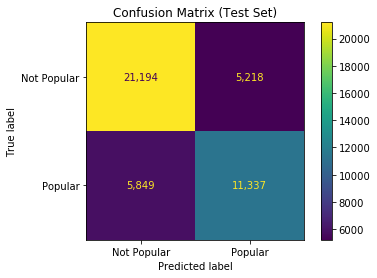

          | Train  | Test   |
          |-----------------|
Precision | 68.45% | 68.48% |
F1 Score  | 67.01% | 67.20% |
ROC-AUC   | 82.15% | 82.28% |


,Model,Precision,F1 Score,ROC-AUC
9,XGBoost,68.48%,67.20%,73.11%
8,Gradient Boosting,68.66%,67.31%,73.21%
7,GridSearch Random Forest,73.02%,32.25%,57.86%
6,Random Forest,72.09%,45.19%,62.31%
5,GridSearch Decision Tree,68.55%,51.48%,64.45%
4,Tuned Decision Tree,68.55%,51.48%,64.45%
3,Vanilla Decision Tree,60.48%,60.14%,67.19%
2,GridSearch LogReg,65.88%,62.15%,69.50%
1,Balanced LogReg,60.61%,66.56%,71.30%
0,Baseline LogReg,65.87%,62.18%,69.51%


In [51]:
sjs.evaluate('XGBoost', XGB, X_train, X_test, y_train, y_test, use_decision_function='no')

In [28]:
XGB2 = XGBClassifier(random_state=SEED)

param_grid = {'max_depth': [3, 5, 7, 10],
              'learning_rate': [.05, .1, .2],  
              'n_estimators' : [10, 100, 1000],
              'colsample_bytree': [.5, 1]
             }

XGB2_GS = GridSearchCV(XGB2, param_grid, scoring='precision', cv=3, verbose=2)
XGB2_GS.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=10, total=   1.0s
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=10, total=   0.9s
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=10 
[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=10, total=   0.8s
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, total=   7.6s
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=100 


KeyboardInterrupt: 

In [ ]:
sjs.evaluate('GridSearch XGBoost', XGB2_GS.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='no')

In [ ]:
sjs.plot_feature_imp(XGB2_GS.best_estimator_, X)

---

## Recommendations

Write recommendations here

---

## Future Work

Write future work here:

1) what is the mean median and mode popularity of the the songs predicted to be popular
2) Future work 2  
3) Future work 3

---
## Edited Visualizations for Non-Technical Presentation